# Getting Started with Centrism Workflow

This jupyter notebook presents the workflow on the backend of the Streamlit web app at https://centrism.streamlit.app/.  I'll be somewhat light on the details here, but you can refer to the web app for the full story.

In [59]:
# Import relevant functions
from functions import *
import matplotlib.pyplot as plt

## I. The Distribution of Voter Beliefs

In [60]:
# set parameters of underlying population.
means = np.array([-1.0,1.0])
variances = np.array([0.5, 0.5])
weights = np.array([0.5, 0.5])

In [61]:
# Compute relevant linspace for left-right spectrum
a = np.argmin(means)
b = np.argmax(means)
m = math.floor(means[a] - 3 * (variances[a] ** (1/2)))
M = math.ceil(means[b] + 3 * (variances[b] ** (1/2)))

# Place relevant political positions along spectrum
n_positions = 100
positions = np.linspace(m,M, n_positions)
df = pd.DataFrame(positions, columns = ["Position"])

# Compute probability density
model = get_gaussian_mixture_model(means, variances, weights)
x = df["Position"].values.reshape(-1,1)
df["Density"] = pdf(x,model)

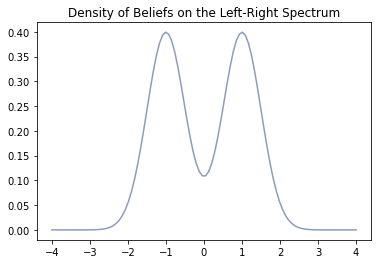

In [62]:
plt.plot(df["Position"], df["Density"], color = LEFT_BLUE)
plt.title("Density of Beliefs on the Left-Right Spectrum")
plt.show()

## II. When Voting is Mandatory

### A. Static Candidates

In [64]:
# Get left and right candidate position.
L = -1.0
R = 2.0

In [65]:
left_share = get_left_share(df = df, left_position = L, right_position = R, model = model)
right_share = get_right_share(df = df, left_position = L, right_position = R, model = model)
left_color, right_color = get_plot_colors(left_share, right_share)

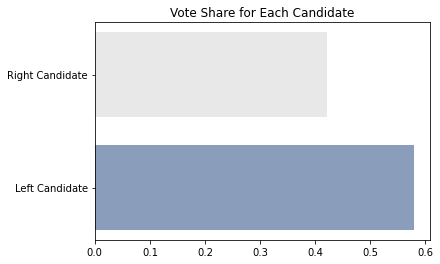

In [68]:
fig, ax = plt.subplots()
ax.barh(y = [-1,1], width = [left_share, right_share], height = 1.5, color = [left_color, right_color])
ax.set_yticks([-1,1])
ax.set_yticklabels(["Left Candidate","Right Candidate"])
plt.title("Vote Share for Each Candidate")
plt.show()

In [70]:
# Compute midpoint and assign voter ranges to candidates
midpoint = (L + R)/2
df_left = df[df["Position"] <= midpoint]
df_right = df[df["Position"] > midpoint]

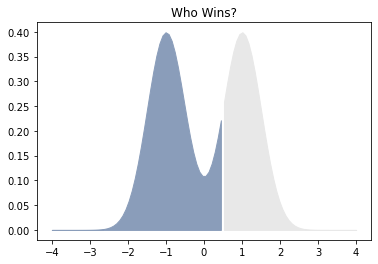

In [71]:
fig, ax = plt.subplots()
ax.fill_between(df_left["Position"], df_left["Density"], color = left_color)
ax.fill_between(df_right["Position"], df_right["Density"], color = right_color)
plt.title("Who Wins?")
plt.show()

### B. Dynamic Candidates

In [76]:
# Compute vote shares with changing left candidate position
ell_positions = np.linspace(m,R,100)
left_shares = []
right_shares = []
for l in ell_positions:
    left_share = get_left_share(df = df,
                              left_position = l, 
                              right_position = R, 
                              model = model)
    left_shares.append(left_share)
    right_share = get_right_share(df = df,
                                left_position = l, 
                                right_position = R, 
                                model = model)
    right_shares.append(right_share)

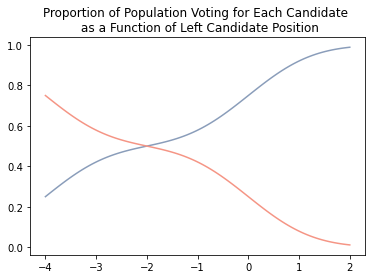

In [77]:
plt.plot(ell_positions, left_shares, color = LEFT_BLUE)
plt.plot(ell_positions, right_shares, color = RIGHT_RED)
plt.title("Proportion of Population Voting for Each Candidate \n as a Function of Left Candidate Position")
plt.show()

In [78]:
# Get alpha value
alpha = 1.0

# Get beta value
beta = 0.2

In [79]:
# Compute left and right candidate positions as candidates move
ell_positions, r_positions = coalescing_candidates(left_position = L, 
                                                  right_position = R, 
                                                  model = model, 
                                                  alpha = alpha, 
                                                  beta = beta)

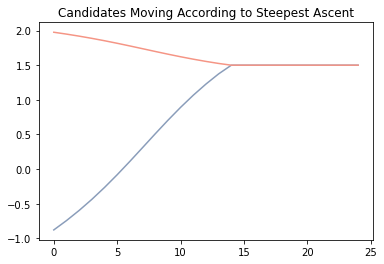

In [80]:
plt.plot(range(len(ell_positions)), ell_positions, color = LEFT_BLUE)
plt.plot(range(len(r_positions)), r_positions, color = RIGHT_RED)
plt.title("Candidates Moving According to Steepest Ascent")
plt.show()

In [81]:
# Get proportion voting for each candidate at time of collision
left_share = get_left_share(df = df, 
                          left_position = ell_positions[-1], 
                          right_position = r_positions[-1], 
                          model = model)
right_share = get_right_share(df = df,
                          left_position = ell_positions[-1], 
                          right_position = r_positions[-1], 
                          model = model)
left_color, right_color = get_plot_colors(left_share, right_share)

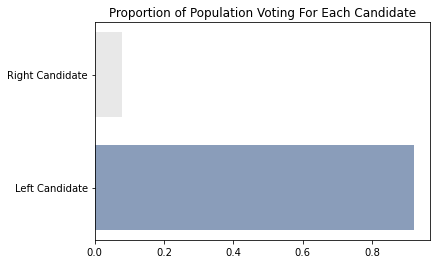

In [82]:
fig, ax = plt.subplots()
ax.barh(y = [-1,1], width = [left_share, right_share], height = 1.5, color = [left_color, right_color])
ax.set_yticks([-1,1])
ax.set_yticklabels(["Left Candidate","Right Candidate"])
plt.title("Proportion of Population Voting For Each Candidate")
plt.show()

## III. When Voting is Not Mandatory

In [83]:
# Get gamma value
gamma = 3.0

In [84]:
ell_positions = np.linspace(m,R, 100)
left_shares = []
right_shares = []
for l in ell_positions:
    left_share = left_share_with_g(left_position = l, 
                                right_position = R, 
                                gamma = gamma, 
                                model = model)
    left_shares.append(left_share)

    right_share = right_share_with_g(left_position = l, 
                                  right_position = R, 
                                  gamma = gamma, 
                                  model = model)
    right_shares.append(right_share)

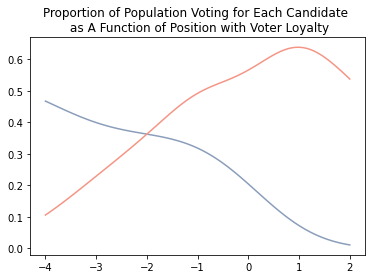

In [87]:
plt.plot(ell_positions, right_shares, color = LEFT_BLUE)
plt.plot(ell_positions, left_shares, color = RIGHT_RED)
plt.title("Proportion of Population Voting for Each Candidate \n as A Function of Position with Voter Loyalty")
plt.show()

In [88]:
# Compute change in vote share as a funciton of loyalty
ell_positions = np.linspace(m,R -.001, 100)
left_derivatives = []
for l in ell_positions:
    D = left_derivative(l,right_position = R, gamma = gamma, model = model)
    left_derivatives.append(D)

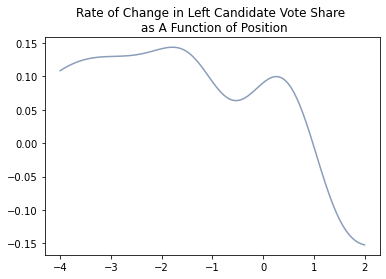

In [91]:
plt.plot(ell_positions, left_derivatives, color = LEFT_BLUE)
plt.title("Rate of Change in Left Candidate Vote Share \n as A Function of Position")
plt.show()

In [92]:
# Read in data for left-candidate final position.
df = pd.read_csv("discontinuity.csv", index_col = 0)

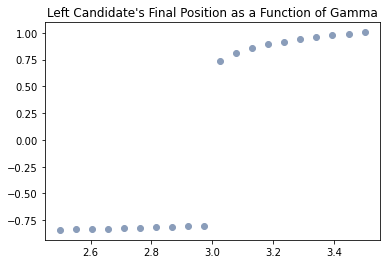

In [93]:
plt.scatter(df["gamma"], df["final_left_position"], color = LEFT_BLUE)
plt.title("Left Candidate's Final Position as a Function of Gamma")
plt.show()